# Problema 4

A questão pede para fazermos um _down-converting_ no sinal, mas como não estamos no Simulink e os dados são gerados por nós mesmos, isso não é necessário pois o sinal não é _up-converted_. Ainda tentei fazer um _up-converting_ para depois fazer um _down-converting_ fazendo algo do tipo

$$Re\{e^{2j\pi f_{0}t}s(t)\}e^{-2j\pi f_{0}t},$$

Mas, nesse caso, não só é meio que inútil, como também polui o código demais. Logo, decidi por abandonar essa empreitada e focar nos outros problemas (bem maiores) a seguir, que me custaram uma boa quantidade de tempo para resolver, e espero conseguir explicar bem o suficiente aqui para que o leitor possa apreciar a mágica que tive que fazer para chegar nesses resultados.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A seguir estão as funções que usei para fazer o ruído AWGN e o ruído de fase. Comecei fazendo o _phase shift_ como ruído, e não um _phase shift_ fixo. Ainda bem que a questão pede algo fixo ao invés de ruído, uma vez que ia ficar bem mais complicado para resolver (apesar de que agora imagino uma saída a partir do que fiz). Enfim, essa função não é útil nesse trabalho, mas ela está aí. :)

In [2]:
# AWGN and Phase Noise
def awgn(s, SNRdB):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    P=np.sum(abs(s)**2)/len(s) # power in the vector -> P=sum (X^{2})/M
    N0=P/gamma # noise spectral density
    n = np.sqrt(N0/2)*(np.random.randn(len(s)) + 1j*np.random.randn(len(s))) # AWGN with unity power
    r = s + n # received signal + noise
    return r

def pnoise(x, phi):
    phase_noise = np.random.randn(len(x)) * phi/180  # adjust multiplier for "strength" of phase noise
    r = x * np.exp(1j*phase_noise)
    return r

Aqui estou usando a mesma função da constelação QAM para a resolução desse problema pois é literalmente equivalente ao QPSK. Isso é inclusive dito na literatura. Após isso, seguem as mesmas funções auxiliares que venho usando para fazer esses trabalhos.

In [3]:
# QPSK(which is 4QAM), modulate and plot
def QAMModem(M): # gray coding into constellation setup ahead
    n=np.arange(0,M) # symbols from 0 to M-1
    a=np.asarray([x^(x>>1) for x in n]) # convert linear to gray code
    D=np.sqrt(M).astype(int) # dimension of our map
    a=np.reshape(a,(D,D)) # slice array on a matrix D x D sized
    oddRows=np.arange(start=1,stop=D,step=2) # identify rows to flip
    a[oddRows,:]=np.fliplr(a[oddRows,:]) # flip the rows
    nGray=np.reshape(a,(M)) # reshape/flatten to 1xM array
    (x,y)=np.divmod(nGray,D) # element-wise quotient and remainder
    Ax=2*x+1-D
    Ay=2*y+1-D
    constellation = Ax + 1j*Ay
    return constellation

def modulate(constellation,inputSymbols):
    modulatedVec = constellation[inputSymbols]
    return modulatedVec

def plotConstellation(constellation,M):
    from math import log2
    fig, axs = plt.subplots(1, 1)
    axs.plot(np.real(constellation),np.imag(constellation),'o')
    for i in range(0,M):
        axs.annotate("{0:0{1}b}".format(i,int(log2(M))),(np.real(constellation[i]),np.imag(constellation[i])))
    axs.set_title('Constellation')
    axs.set_xlabel('I')
    axs.set_ylabel('Q')

Ok, antes de seguir para os itens da questão em si, vou tentar explicar as magias que tive que fazer para resolver o impasse que veio da estimação de fase. Primeiro, vejamos mais uma vez a constelação QAM modulada com ruído a seguir:

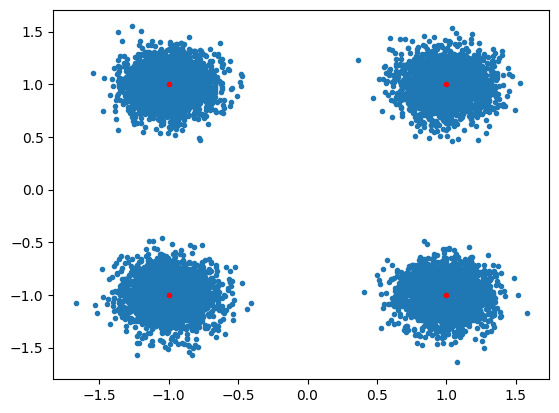

In [4]:
M=2**2 # number of points in QAM
num_symbols = int(1e4) # number of symbols
inputSyms = np.random.randint(low=0, high = M, size=num_symbols)
constellation = QAMModem(M)
C = modulate(constellation,inputSyms)
SNRdB=16
r = awgn(C,SNRdB) # adds awgn
fig, axs = plt.subplots(1,1)
axs.plot(np.real(r), np.imag(r), '.')
axs.plot(np.real(constellation), np.imag(constellation), '.r')
plt.show()

Após isso, vejamos o mesmo só que com um _phase shift_ de $\pi/4$.

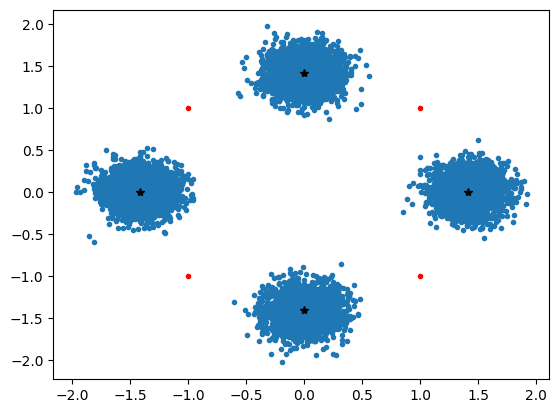

In [5]:
M=2**2 # number of points in QAM
num_symbols = int(1e4) # number of symbols
inputSyms = np.random.randint(low=0, high = M, size=num_symbols)
constellation = QAMModem(M)
phase_shift = np.pi/4
shifted_constellation = constellation * np.exp(1j*np.pi/4)
C = modulate(constellation,inputSyms)
SNRdB=16
r = awgn(C,SNRdB) # adds awgn
r = r * np.exp(1j*phase_shift) # adds phase shift
fig, axs = plt.subplots(1,1)
axs.plot(np.real(r), np.imag(r), '.') # received symbols, with noise and phase shifted
axs.plot(np.real(constellation), np.imag(constellation), '.r') # constellation
axs.plot(np.real(shifted_constellation), np.imag(shifted_constellation), '*k') # shifted constellation
plt.show()

A grande dificuldade aqui está, obviamente, em como estimar a fase sem atrapalhar o demodulador (e, possivelmente, melhorando o processo para esse caso). E é daí de onde vem a grande dificuldade, uma vez que se seguíssemos a lógica de um _estimador de fase simples_, logo chegaríamos no seguinte:

$$\hat{\theta}_{r}=\argmin |\theta_{r} - \bm{\theta}_{c}|$$

Que é relativamente fácil de se implementar. O problema nasce justamente de como as linguagens de programação calculam o ângulo. Vejamos o seguinte exemplo: Se temos uma constelação $x_{ref}=\{(-1,0);(1,0);(0,1);(0,-1)\}$, e os seguintes pontos $x_{1}=(-1,0.2)$ e $x_{2}=(-1,-.2)$, a estimativa deveria ser a mesma para ambos, $\hat{\theta}_{r}=(-1,0)$. No entanto, como podemos ver a seguir não é bem o caso.

In [6]:
x_ref=np.array([
    -1,
    1,
    1j,
    -1j
])
x1=-1+.2j
x2=-1-.2j
print('Ângulo de x1: ', np.angle(x1))
print('Diferença de ângulos entre x1 e x_ref: ', np.abs(np.angle(x1)-np.angle(x_ref)))
print('Ângulo de x2: ', np.angle(x2))
print('Diferença de ângulos entre x2 e x_ref: ', np.abs(np.angle(x2)-np.angle(x_ref)))
print('Posição em x_ref que a fase corrigida é predita para x1: ', np.argmin(np.abs(np.angle(x1)-np.angle(x_ref))))
print('Posição em x_ref que a fase corrigida é predita para x2: ', np.argmin(np.abs(np.angle(x2)-np.angle(x_ref))))

Ângulo de x1:  2.9441970937399127
Diferença de ângulos entre x1 e x_ref:  [0.19739556 2.94419709 1.37340077 4.51499342]
Ângulo de x2:  -2.9441970937399127
Diferença de ângulos entre x2 e x_ref:  [6.08578975 2.94419709 4.51499342 1.37340077]
Posição em x_ref que a fase corrigida é predita para x1:  0
Posição em x_ref que a fase corrigida é predita para x2:  3


E essa bagunça se deve ao fato de que a função ângulo aqui vai de $(-\pi,\pi]$. E esse nó cego é um pouco difícil de resolver. Pensei em usar métodos de correção de fase mais robustos e tudo mais, como um Costas Loop ou outra função PLL, mas, com toda sinceridade, entender tudo isso adaptar ao meu código estava se provando ser bem difícil. Depois de bastante tempo :), cheguei na seguinte solução:

1. Primeiro temos que _corrigir_ a fase em relação a **constelação _shiftada_**.
2. Uma vez que é decidido de qual ponto da _constelação shiftada_ o sinal recebido faz parte, basta que façamos, para um sinal recebido $r$:
$$\tilde{r}=||r||\cos(\hat{\theta})+||r||\sin(\hat{\theta})$$
3. Por fim:
$$\hat{r}_{phase}=\frac{\tilde{r}}{e^{j\theta_{shift}}}$$
4. Desse ponto em diante, podemos prosseguir com o detector ML.

Para fazer isso, no primeiro passo usei da mesma ideia descrita anteriormente, mas com o uso de uma função que calcula o ângulo entre dois vetores, mas que retorne o resultado entre $(0,\pi]$ **especificamente**. Ressalto isso pois já tentei resolver o problema (de outras formas) com outras funções que retornam o ângulo entre dois vetores e não deu muito certo. Enfim, com essa função eu analiso, para cada sinal recebido shiftado a qual ponto da constelação shiftada ele pertence e os passos seguintes são feitos. Essas funções são escritas abaixo, e implementadas diretamente no demodulador por uma condicional, para maior conveniência.

In [7]:
# phase estimation & demodulation
def angle_between(v1, v2):
    from numpy.linalg import norm
    angle_difference = np.arccos((v1@v2)/(norm(v1)*norm(v2))) # spits it out in [0,pi]
    return angle_difference

def logical_phase_estimator(constellation,receivedSyms,phase_shift):
    # cartesian coordinates of receivedSyms
    rs_coords = np.column_stack((np.real(receivedSyms),np.imag(receivedSyms)))
    # cartesian coordinates of shifted constellation
    shifted_constellation = constellation * np.exp(1j*phase_shift)
    sc_coords = np.column_stack((np.real(shifted_constellation),np.imag(shifted_constellation)))
    # map the phase to the nearest qpsk phase
    corrected_signal=np.zeros(len(receivedSyms),dtype=complex)
    for i in np.arange(len(receivedSyms)):
        aux=np.zeros(len(shifted_constellation))
        for k in np.arange(len(sc_coords)):
            aux[k]=angle_between(rs_coords[i],sc_coords[k])
        estimate=shifted_constellation[np.argmin(aux)]
        vx=np.abs(receivedSyms[i])*np.cos(np.angle(estimate))
        vy=np.abs(receivedSyms[i])*np.sin(np.angle(estimate))
        corrected_signal[i]=(vx+1j*vy)/np.exp(1j*phase_shift)
    return corrected_signal

def demodulate(constellation,receivedSyms,phase_estimation=False,phase_shift=0):
    # received vector and reference in cartesian form
    if phase_estimation==True:
        receivedSyms=logical_phase_estimator(constellation,receivedSyms,phase_shift)
    from scipy.spatial.distance import cdist
    XA = np.column_stack((np.real(receivedSyms),np.imag(receivedSyms)))
    XB = np.column_stack((np.real(constellation),np.imag(constellation)))
        
    d = cdist(XA,XB,metric='euclidean') #compute pair-wise Euclidean distances
    detectedSyms=np.argmin(d,axis=1)#indices corresponding minimum Euclid. dist.
    return detectedSyms

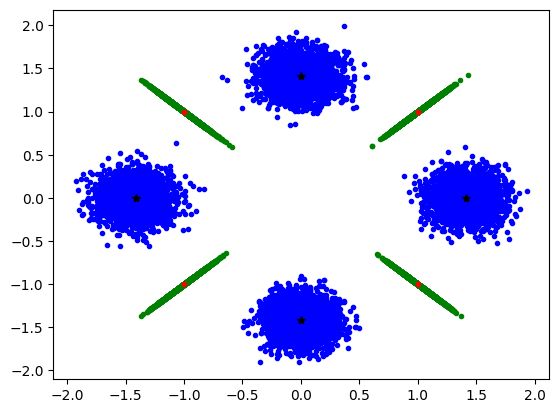

In [8]:
M=2**2 # number of points in QAM
num_symbols = int(1e4) # number of symbols
inputSyms = np.random.randint(low=0, high = M, size=num_symbols)
constellation = QAMModem(M)
phase_shift = np.pi/4
shifted_constellation = constellation * np.exp(1j*np.pi/4)
C = modulate(constellation,inputSyms)
SNRdB=16
r = awgn(C,SNRdB) # adds awgn
r = r * np.exp(1j*phase_shift) # adds phase shift
corrected_phase=logical_phase_estimator(constellation,r,phase_shift)
demodulated=demodulate(constellation,r,phase_estimation=True,phase_shift=phase_shift)
fig, axs = plt.subplots(1,1)
axs.plot(np.real(corrected_phase),np.imag(corrected_phase),'.g') # phase corrected [noisy + phase shifted] constellation
axs.plot(np.real(r), np.imag(r), '.b') # received symbols, with noise and phase shifted
axs.plot(np.real(constellation), np.imag(constellation), '.r') # constellation
axs.plot(np.real(shifted_constellation), np.imag(shifted_constellation), '*k') # shifted constellation
#axs.plot(np.real(constellation[demodulated]),np.imag(constellation[demodulated]),'.') # just to see them in the
#graph, for testing purposes
plt.show()

Como se pode ver acima, desse ponto adiante basta que façamos o resto demodulação como sempre. Daqui em diante, segue a solução do problema em si, como pedido. o7

### 1: Para efeitos de demonstração, fazemos o item a com 10 símbolos apenas.

In [9]:
p = 2 # 4 power
M=2**p # number of points in QAM
num_symbols = int(10) # number of symbols
inputSyms = np.random.randint(low=0, high = M, size=num_symbols)
constellation = QAMModem(M)
C = modulate(constellation,inputSyms)

print(inputSyms)
demodulate(constellation,C)

[3 3 2 2 2 3 0 1 2 3]


array([3, 3, 2, 2, 2, 3, 0, 1, 2, 3])

### 2: AWGN -> BER

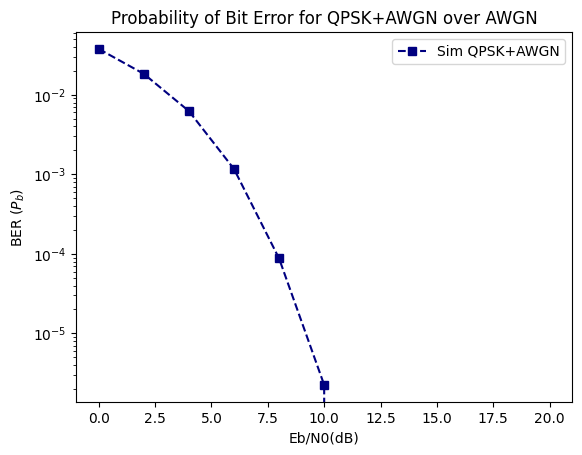

In [10]:
#---------Input Fields------------------------
nSym = 10**6 # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=0,stop = 22, step = 2) # Eb/N0 range in dB for simulation
mod_type1 = 'QPSK+AWGN'
arrayOfM = [4]

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim1 = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = QAMModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim1[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim1/M,color = colors[i],marker='s',linestyle='--',label='Sim '+mod_type1.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = psk_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory/M,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())


ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for '+str(mod_type1)+' over AWGN')
ax.legend()
#ax.set_ylim(1e-6,1) # if you don't set the limit it will get goofy. leave this untouched.

### 3. AWGN + $\phi=\pi/4$ -> BER

(0.01, 0.4)

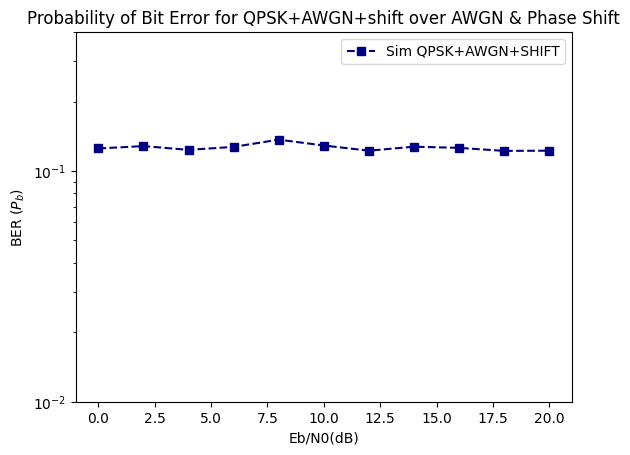

In [11]:
#---------Input Fields------------------------
nSym = 10**3 # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=0,stop = 22, step = 2) # Eb/N0 range in dB for simulation
mod_type2 = 'QPSK+AWGN+shift'
arrayOfM = [4]

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim2 = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = QAMModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        phase_shift = np.pi/4
        receivedSyms = receivedSyms * np.exp(1j*phase_shift)
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim2[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim2/M,color = colors[i],marker='s',linestyle='--',label='Sim '+mod_type2.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = psk_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory/M,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())

ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for '+str(mod_type2)+' over AWGN & Phase Shift')
ax.legend()
ax.set_ylim(1e-2,4e-1) # if you don't set the limit it will get goofy. leave this untouched.

### 4. AWGN + $\phi=\pi/4$ -> Logical Phase Estimator -> BER

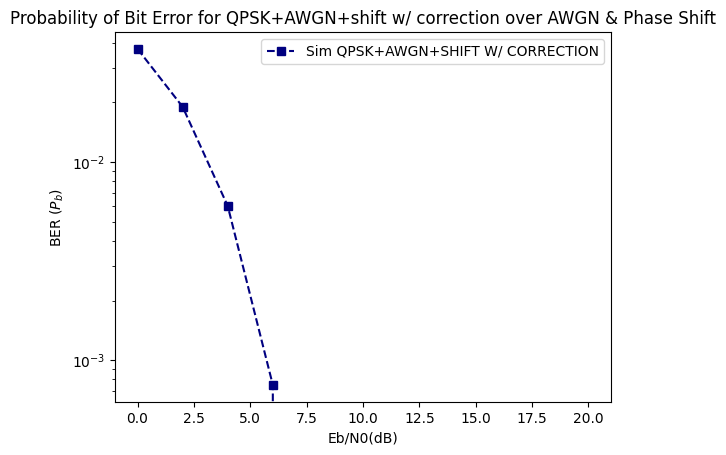

In [12]:
#---------Input Fields------------------------
nSym = 10**3 # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=0,stop = 22, step = 2) # Eb/N0 range in dB for simulation
mod_type3 = 'QPSK+AWGN+shift w/ correction'
arrayOfM = [4]

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim3 = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = QAMModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        phase_shift = np.pi/4
        receivedSyms = receivedSyms * np.exp(1j*phase_shift)
        detectedSyms = demodulate(constellation,receivedSyms,phase_estimation=True,phase_shift=phase_shift)
        
        SER_sim3[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim3/M,color = colors[i],marker='s',linestyle='--',label='Sim '+mod_type3.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = psk_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory/M,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())

ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for '+str(mod_type3)+' over AWGN & Phase Shift')
ax.legend()
#ax.set_ylim(1e-6,1) # if you don't set the limit it will get goofy. leave this untouched.

### 5. Everything together + Theoretical BER

(1e-06, 1)

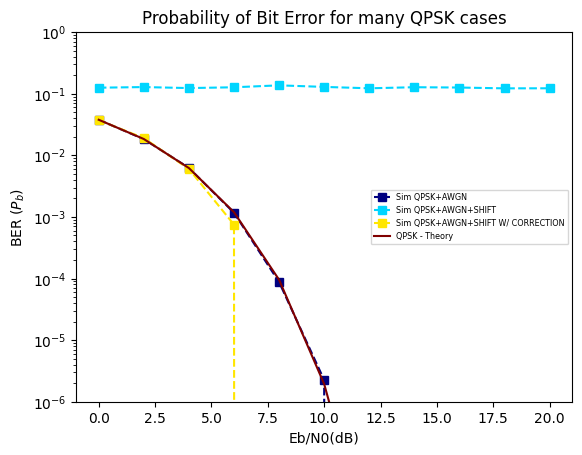

In [13]:
# função da SER teórica do qam
def qam_awgn(M,gamma_s):
    from scipy.special import erfc
    if (M==1) or (np.mod(np.log2(M),2)!=0): # M not a even power of 2
        raise ValueError('Only square MQAM supported. M must be even power of 2')
    SERs = 1-(1-(1-1/np.sqrt(M))*erfc(np.sqrt(3/2*gamma_s/(M-1))))**2
    return SERs

colors = plt.cm.jet(np.linspace(0,1,4)) # colormap
mod_type1 = 'QPSK+AWGN'
mod_type2 = 'QPSK+AWGN+shift'
mod_type3 = 'QPSK+AWGN+shift w/ correction'
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dBs,SER_sim1/M,color = colors[0],marker='s',linestyle='--',label='Sim '+mod_type1.upper())
ax.semilogy(EbN0dBs,SER_sim2/M,color = colors[1],marker='s',linestyle='--',label='Sim '+mod_type2.upper())
ax.semilogy(EbN0dBs,SER_sim3/M,color = colors[2],marker='s',linestyle='--',label='Sim '+mod_type3.upper())
ax.semilogy(EbN0dBs,qam_awgn(M,np.log2(M)*(10**(EbN0dBs/10)))/M,color = colors[3],linestyle='-',label='QPSK - Theory')
ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for many QPSK cases')
ax.legend(loc='center right',fontsize='xx-small')
ax.set_ylim(1e-6,1) # if you don't set the limit it will get goofy. leave this untouched.